In [10]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
%matplotlib inline
import numpy as np
import math
from functools import partial

In [11]:
from um_util import *
# from um_models import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from tqdm.notebook import tqdm

In [13]:
def get_coef_significance(X, Y):    
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y
#     log_reg = sm.Logit(Y_train, X_train).fit()
    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    return pd.read_html(summary.as_html(), header=0, index_col=0)[0], lin_reg

In [14]:
def check_pval(pval):
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [15]:
def ttest(c, e):
    t_val, p = stats.ttest_ind(c, e, equal_var=False) 
    check_pval(p)
    return p

In [16]:
# ! pip install iterative-stratification

## Датасет

In [17]:
# please download data from: 
# http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz

inp_df = pd.read_csv('criteo-uplift-v2.1.csv')

features = ['f{}'.format(n) for n in range(12)]
inp_df[features] = normalize(inp_df[features], axis=0, norm='l2')
df = inp_df

X = features
y = 'visit'
t = 'treatment'

In [18]:
cat_features = ['f1', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
noncat_features = list(inp_df.columns.difference(cat_features + [y,t,'conversion', 'exposure']))

In [22]:
t, p = stats.ttest_ind(df.loc[df['treatment'] == 1, 'visit'], df.loc[df['treatment'] == 0, 'visit'], equal_var=False, random_state=3)
print(f'Full data p-value: {p}')

Full data p-value: 0.0


In [23]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,0.000166,0.000267,0.000284,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
1,0.000166,0.000267,0.000285,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
2,0.000166,0.000267,0.000284,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
3,0.000166,0.000267,0.000285,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
4,0.000166,0.000267,0.000286,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0


## Эксперименты с уровнем значимости

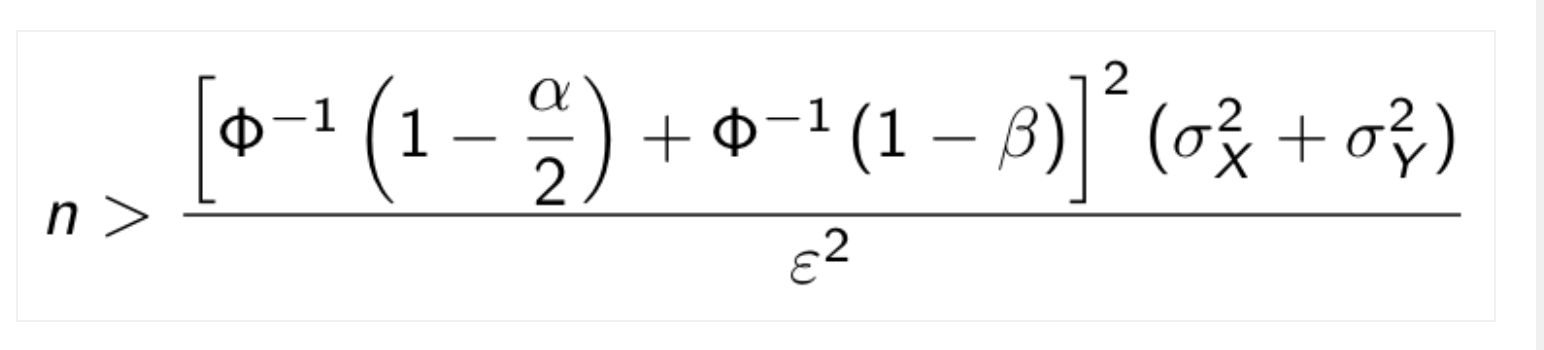

In [24]:
def get_n_samples(alpha, beta, eps, scale=1, alternative=2):
    if alternative == 1:
        f_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    else:
        f_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
        
    f_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    n_min = ((f_alpha + f_beta) ** 2 * (s_c * scale + s_t)) // (scale * eps**2)
    return n_min

In [40]:
def ttest(x, y, randomized=False, alternative=2, verbose=False):
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    s_x = np.var(x, ddof=1)
    s_y = np.var(y, ddof=1)
    dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
    
    if randomized:
        b0 = n_x ** 0.75
        b1 = n_y ** 0.75
        
        
        theta_x = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b0)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_x // 4 + 1))
        
        theta_x = theta_x[:n_x]
    #     theta_x = theta_x / np.linalg.norm(theta_x)

        theta_y = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b1)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_y // 4 + 1))
        
        theta_y = theta_y[:n_y]
    #     theta_y = theta_y / np.linalg.norm(theta_y)

        t_val = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
        
        if alternative == 1:
            p = stats.t.cdf(t_val, dof)
        else:  
            p = 2*(stats.t.cdf(-abs(t_val), dof))
        
        
    else: 
        if alternative == 1:
            t_val, p = stats.ttest_ind(x, y, equal_var=False, alternative='less')
        else:  
            t_val, p = stats.ttest_ind(x, y, equal_var=False) 
    
    if verbose:
        check_pval(p)
    return (t_val, p)

In [41]:
def kl_div(x, y):
    p = x.mean()
    q = y.mean()
    
    pk = np.array([p, 1 - p])
    qk = np.array([q, 1 - q])
    
    kl_stat = x.shape[0] * stats.entropy(pk, qk)
    dof = 1
    p = stats.chi2.sf(kl_stat, dof)
    return kl_stat, p

In [42]:
def calc_m(table, i, j, n):
    x_ip = table[i, :].sum()
    x_pj = table[:, j].sum()
    return x_ip * x_pj / n

def power_div(a, b, l=2/3):
    n = len(a) + len(b)
    r = 2
    c = 2
    table = np.array([[a[a==0].shape[0], a[a==1].shape[0]], 
                      [b[b == 0].shape[0], b[b==1].shape[0]]])
    #print(table)
    pd_stat = 0
    for i in range(r):
        for j in range(c):
            m_ij= calc_m(table, i, j, n)
            pd_stat += table[i][j] * ((table[i][j] / m_ij) ** l - 1)
    
    pd_stat *= 2 / (l * (l + 1)) 
    dof = (r - 1) * (c - 1)
    p = stats.chi2.sf(pd_stat, dof)
    
    return pd_stat, p

## Экспримент c фиксированным уровнем значимости $\alpha$

#### Маленькая выборка

In [164]:
p_c = 0.3
p_t = 0.3

alpha = 0.05
beta = 0.2
eps = 0.4

scale = 1.0
s_c = p_c*(1-p_c)
s_t = p_t*(1-p_t)

control_n = int(get_n_samples(alpha, beta, eps, scale=scale, alternative=2))
treatment_n = int(scale * control_n)
control_n, treatment_n


(20, 20)

In [172]:
N_generations = 10_000

p_vals_standart = []
p_vals_random = []
p_vals_pd = []
p_vals_kl = []

t_vals_standart = []
t_vals_random = []
pd_vals = []
kl_vals = []


alpha = 0.05

for i in tqdm(range(N_generations)):
    y_control = np.random.binomial(1, p_c, size=control_n)
    y_treatment = np.random.binomial(1, p_t, size=treatment_n)
    
    (t_stat_orig, p_value_orig) = ttest(y_control, y_treatment, randomized = False, alternative=2)
    (t_stat_rand, p_value_rand) = ttest(y_control, y_treatment, randomized=True, alternative=2)
    
    t_vals_standart.append(t_stat_orig)
    t_vals_random.append(t_stat_rand)
    
    p_vals_standart.append(p_value_orig)
    p_vals_random.append(p_value_rand)
    

first_error_orig = np.mean(np.array(p_vals_standart) <= alpha)
first_error_rand = np.mean(np.array(p_vals_random) <= alpha)



k_d_orig_norm = stats.ks_1samp(t_vals_standart, stats.norm.cdf).statistic
k_d_rand_norm = stats.ks_1samp(t_vals_random, stats.norm.cdf).statistic



# # for 2sided
chisquare_cdf = partial(stats.chi2.cdf, df=1)
k_d_orig_chi = stats.ks_1samp(np.array(t_vals_standart) ** 2, chisquare_cdf).statistic
k_d_rand_chi = stats.ks_1samp(np.array(t_vals_random) ** 2, chisquare_cdf).statistic

  0%|          | 0/10000 [00:00<?, ?it/s]

Размер выборки: 20
Ошибка первого рода в стандартном тесте: 0.0546, в рандомном: 0.0486


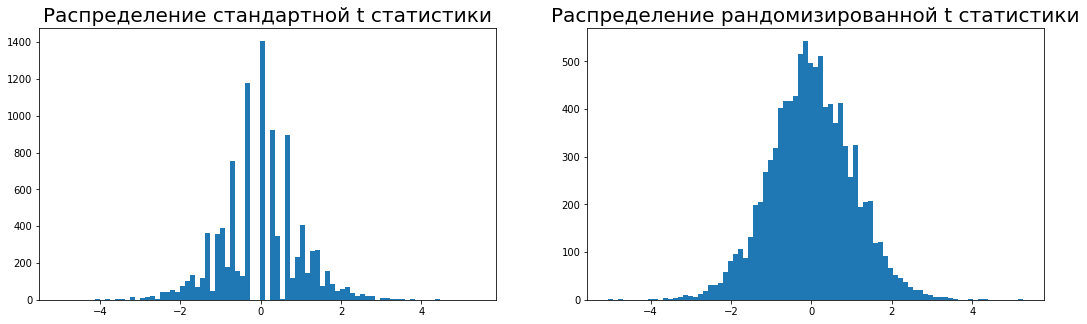

In [173]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

_ = ax1.hist(t_vals_standart, bins='auto')
ax1.set_title(f'Распределение стандартной t статистики', fontsize=20)

_ = ax2.hist(t_vals_random, bins='auto')
ax2.set_title(f'Распределение рандомизированной t статистики', fontsize=20)
plt.show()



In [174]:
data = [[first_error_orig, k_d_orig_norm, k_d_orig_chi], [first_error_rand, k_d_rand_norm, k_d_rand_chi]]
results = pd.DataFrame(data=data, index=['original ttest', 'randomized ttest'], 
                       columns=['1 type error', 'kolmogorov dist normal',  'kolmogorov dist 𝝌^2'])
results

,1 type error,kolmogorov dist normal,kolmogorov dist 𝝌^2
original ttest,0.0546,0.0725,0.1407
randomized ttest,0.0486,0.0238,0.0385


#### Большая выборка

In [175]:
p_c = 0.3
p_t = 0.3

alpha = 0.05
beta = 0.2
eps = 0.03

scale = 1.0
s_c = p_c*(1-p_c)
s_t = p_t*(1-p_t)

control_n = int(get_n_samples(alpha, beta, eps, scale=scale, alternative=2))
treatment_n = int(scale * control_n)
control_n, treatment_n


(3662, 3662)

In [177]:
N_generations = 10_000

p_vals_standart = []
p_vals_random = []
p_vals_pd = []
p_vals_kl = []

t_vals_standart = []
t_vals_random = []
pd_vals = []
kl_vals = []


alpha = 0.05

for i in tqdm(range(N_generations)):
    y_control = np.random.binomial(1, p_c, size=control_n)
    y_treatment = np.random.binomial(1, p_t, size=treatment_n)
    
    (t_stat_orig, p_value_orig) = ttest(y_control, y_treatment, randomized = False, alternative=2)
    (t_stat_rand, p_value_rand) = ttest(y_control, y_treatment, randomized=True, alternative=2)

    t_vals_standart.append(t_stat_orig)
    t_vals_random.append(t_stat_rand)
    
    p_vals_standart.append(p_value_orig)
    p_vals_random.append(p_value_rand)
    

first_error_orig = np.mean(np.array(p_vals_standart) <= alpha)
first_error_rand = np.mean(np.array(p_vals_random) <= alpha)



k_d_orig_norm = stats.ks_1samp(t_vals_standart, stats.norm.cdf).statistic
k_d_rand_norm = stats.ks_1samp(t_vals_random, stats.norm.cdf).statistic


# # for 2sided
chisquare_cdf = partial(stats.chi2.cdf, df=1)
k_d_orig_chi = stats.ks_1samp(np.array(t_vals_standart) ** 2, chisquare_cdf).statistic
k_d_rand_chi = stats.ks_1samp(np.array(t_vals_random) ** 2, chisquare_cdf).statistic

  0%|          | 0/10000 [00:00<?, ?it/s]

Размер выборки: 3662
Ошибка первого рода в стандартном тесте: 0.0509, в рандомном: 0.0458


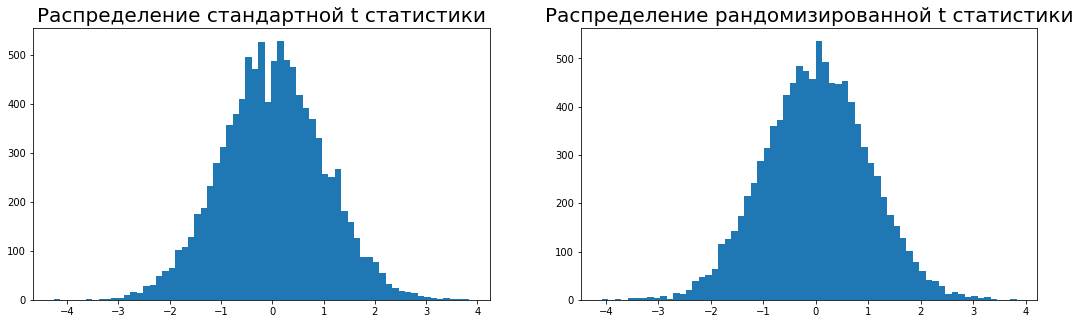

In [178]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

_ = ax1.hist(t_vals_standart, bins='auto')
ax1.set_title(f'Распределение стандартной t статистики', fontsize=20)

_ = ax2.hist(t_vals_random, bins='auto')
ax2.set_title(f'Распределение рандомизированной t статистики', fontsize=20)
plt.show()

